In [ ]:
import numpy
import pandas as pd
import os
import csv
import ast
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.utils import assets_directory
from openfisca_france_indirect_taxation.examples.utils_example import (
    wavg,
    collapse,
    dataframe_by_group,
    graph_builder_bar,
    df_weighted_average_grouped)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame

In [ ]:
from openfisca_france_indirect_taxation.Calage_consommation_bdf import (
    get_cn_aggregates,
    get_inflators_by_year)

In [ ]:
get_cn_aggregates(2018)

c:\Users\veve1\miniconda3\envs\openfiscaenv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,conso_CN_2018
Code,
poste_01_1_1,2.389110e+10
poste_01_1_2,3.038930e+10
poste_01_1_3,7.270900e+09
poste_01_1_4,1.901400e+10
poste_01_1_5,3.307400e+09
...,...
poste_12_3_3_1,0.000000e+00
poste_12_8_1,0.000000e+00
poste_12_9_1,0.000000e+00


In [4]:
input = get_input_data_frame(2017)

In [ ]:
inflators = get_inflators_by_year(rebuild = True, year_range=[2024],data_year = 2017)

In [7]:
input['rev701_pond'] = input['somme_libre_recue']*input['pondmen']
input['rev701_pond'].sum()

5257306613.928457

In [8]:
float(inflators.get(2024).get('rev_disponible') * input['rev701_pond'].sum())

8559667489.895596

In [9]:
input.loc[input['revact'] != input['act_indpt'] + input['salaires'], ['revact','act_indpt','salaires']]

,revact,act_indpt,salaires
185,4118,0,1120
318,24,0,0
380,2,0,0
508,54162,0,25170
584,14455,0,1480
...,...,...,...
11370,28066,0,11730
11578,77996,0,77300
11778,65148,0,33260
11831,111173,-2410,40580


In [10]:
input['rev_etranger'] = input['revact'] - input['act_indpt'] - input['salaires']
input['rev_etranger_pond'] = input['rev_etranger'] * input['pondmen']
float( inflators.get(2024).get('rev_disponible') * input['rev_etranger_pond'].sum())

4750706653.297848

In [ ]:
data_year = 2017
inflators_by_year = get_inflators_by_year(rebuild = True, year_range = range(2017, 2025), data_year = data_year)
simulated_variables = ['tva_taux_plein',
'tva_taux_intermediaire',
 'tva_taux_reduit',
 'tva_taux_super_reduit',
 'tva_total',
 'depenses_tva_exonere',
 'depenses_tva_taux_plein',
 'depenses_tva_taux_intermediaire',
 'depenses_tva_taux_reduit',
 'depenses_tva_taux_super_reduit',
 'rev_disponible',
 'rev_disp_yc_loyerimpute',
 'loyer_impute',
 'depenses_tot',
 'depenses_totales',
 'pondmen',
]

agregates = pd.DataFrame(columns = simulated_variables)
for year in range(2017,2025) :
    inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])
    survey_scenario = SurveyScenario.create(
        inflation_kwargs = inflation_kwargs,
        year = year,
        data_year = data_year
        )
    df_sum = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'sum')
    agregates.loc[year] = df_sum.sum()

c:\Users\veve1\miniconda3\envs\openfiscaenv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
c:\users\veve1\documents\openfisca-france-indirect-taxation\openfisca_france_indirect_taxation\projects\TVA_Herve_IPP\new_calage_bdf_cn.py:184: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_bdf_postes_cn[poste] = 0


In [13]:
agregates 

,tva_taux_plein,tva_taux_intermediaire,tva_taux_reduit,tva_taux_super_reduit,tva_total,depenses_tva_exonere,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,depenses_tot,depenses_totales,pondmen
2017,7.655690e+10,1.291591e+10,1.072761e+10,2.084693e+08,1.004089e+11,1.622514e+11,4.593414e+11,1.420750e+11,2.057751e+11,1.013558e+10,1.197964e+12,1.387077e+12,1.891127e+11,9.795786e+11,8.173271e+11,8.445859e+10
2018,7.887971e+10,1.348114e+10,1.097076e+10,2.025673e+08,1.035342e+11,1.694745e+11,4.732783e+11,1.482926e+11,2.104391e+11,9.848630e+09,1.234271e+12,1.426805e+12,1.925339e+11,1.011333e+12,8.418586e+11,8.445859e+10
2019,7.957310e+10,1.416258e+10,1.123779e+10,2.006289e+08,1.051741e+11,1.752894e+11,4.774386e+11,1.557884e+11,2.155613e+11,9.754388e+09,1.278664e+12,1.475381e+12,1.967170e+11,1.033832e+12,8.585427e+11,8.445859e+10
2020,7.421820e+10,1.070282e+10,1.077048e+10,1.843186e+08,9.587583e+10,1.733112e+11,4.453092e+11,1.177311e+11,2.065974e+11,8.961396e+09,1.289747e+12,1.489995e+12,2.002478e+11,9.519103e+11,7.785991e+11,8.445859e+10
2021,8.110873e+10,1.249428e+10,1.101083e+10,1.942183e+08,1.048081e+11,1.798165e+11,4.866524e+11,1.374370e+11,2.112078e+11,9.442709e+09,1.358404e+12,1.562187e+12,2.037834e+11,1.024556e+12,8.447399e+11,8.445859e+10
2022,8.553721e+10,1.663396e+10,1.207359e+10,1.995504e+08,1.144443e+11,1.950986e+11,5.132232e+11,1.829736e+11,2.315934e+11,9.701952e+09,1.434894e+12,1.642992e+12,2.080976e+11,1.132591e+12,9.374922e+11,8.445859e+10
2023,8.924868e+10,1.818491e+10,1.323556e+10,2.004926e+08,1.208696e+11,2.355489e+11,5.354921e+11,2.000340e+11,2.538821e+11,9.747758e+09,1.560302e+12,1.773999e+12,2.136968e+11,1.234705e+12,9.991559e+11,8.445859e+10
2024,9.181751e+10,1.870832e+10,1.361652e+10,2.062633e+08,1.243486e+11,2.423287e+11,5.509051e+11,2.057916e+11,2.611896e+11,1.002833e+10,1.605212e+12,1.825060e+12,2.198476e+11,1.270243e+12,1.027915e+12,8.445859e+10


In [14]:
agregates[['depenses_tva_taux_plein', 'depenses_tva_taux_intermediaire' , 'depenses_tva_taux_reduit','depenses_tva_taux_super_reduit','depenses_tva_exonere']]

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,depenses_tva_exonere
2017,4.593414e+11,1.420750e+11,2.057751e+11,1.013558e+10,1.622514e+11
2018,4.732783e+11,1.482926e+11,2.104391e+11,9.848630e+09,1.694745e+11
2019,4.774386e+11,1.557884e+11,2.155613e+11,9.754388e+09,1.752894e+11
2020,4.453092e+11,1.177311e+11,2.065974e+11,8.961396e+09,1.733112e+11
2021,4.866524e+11,1.374370e+11,2.112078e+11,9.442709e+09,1.798165e+11
2022,5.132232e+11,1.829736e+11,2.315934e+11,9.701952e+09,1.950986e+11
2023,5.354921e+11,2.000340e+11,2.538821e+11,9.747758e+09,2.355489e+11
2024,5.509051e+11,2.057916e+11,2.611896e+11,1.002833e+10,2.423287e+11


In [15]:
tva_cpo = pd.DataFrame(data = {'' : [2015,2016,2017,2018,2019,2020,2021] , 'tva (CPO)' : [152.6, 155.4, 162.9, 168.6, 174.9, 162.6, 185.9]})
tva_cpo.set_index('', inplace= True)

In [16]:
tva_cpo.loc[:,'tva (CPO)'] = tva_cpo.loc[:,'tva (CPO)'] * 1e9

In [17]:
compare_agregate = tva_cpo.merge(agregates['tva_total'], left_index = True, right_index = True)
compare_agregate.rename(columns={'tva_total' : 'tva (BdF)'}, inplace = True)
compare_agregate = (compare_agregate * 1e-9).round(1)
compare_agregate.loc[:,'ratio'] = (compare_agregate.loc[:,'tva (BdF)'] / compare_agregate.loc[:,'tva (CPO)'] * 100).round(2) 

In [18]:
compare_agregate

,tva (CPO),tva (BdF),ratio
2017,162.9,100.4,61.63
2018,168.6,103.5,61.39
2019,174.9,105.2,60.15
2020,162.6,95.9,58.98
2021,185.9,104.8,56.37


In [19]:
compare_agregate['growth rate (CPO)'] = compare_agregate['tva (CPO)'].pct_change()
compare_agregate['growth rate (BDF)'] = compare_agregate['tva (BdF)'].pct_change()
compare_agregate

,tva (CPO),tva (BdF),ratio,growth rate (CPO),growth rate (BDF)
2017,162.9,100.4,61.63,NaN,NaN
2018,168.6,103.5,61.39,0.034991,0.030876
2019,174.9,105.2,60.15,0.037367,0.016425
2020,162.6,95.9,58.98,-0.070326,-0.088403
2021,185.9,104.8,56.37,0.143296,0.092805


In [20]:
tva_plf= pd.DataFrame(data = {'' : [2021,2022,2023,2024] , 'tva (Compta Nat)' : [186.7,202.7,208.4,210.1]})
tva_plf.set_index('', inplace= True)
tva_plf.loc[:,'tva (Compta Nat)'] = tva_plf.loc[:,'tva (Compta Nat)'] * 1e9

In [21]:
compare_agregate_plf = tva_plf.merge(agregates['tva_total'], left_index = True, right_index = True)
compare_agregate_plf.rename(columns={'tva_total' : 'tva (BdF)'}, inplace = True)
compare_agregate_plf = compare_agregate_plf * 1e-9
compare_agregate_plf = compare_agregate_plf.round(1)
compare_agregate_plf.loc[:,'ratio'] = (compare_agregate_plf.loc[:,'tva (BdF)'] / compare_agregate_plf.loc[:,'tva (Compta Nat)'] * 100).round(2) 

In [22]:
compare_agregate_plf

,tva (Compta Nat),tva (BdF),ratio
2021,186.7,104.8,56.13
2022,202.7,114.4,56.44
2023,208.4,120.9,58.01
2024,210.1,124.3,59.16


In [23]:
parametres_fiscalite_file_path = os.path.join(
            assets_directory,
            'legislation',
            'T_3217.xlsx'
            )

In [24]:
compta_nat = pd.read_excel(parametres_fiscalite_file_path, header = 2)
compta_nat.drop('Unnamed: 0', axis = 1, inplace = True)
compta_nat = compta_nat.loc[compta_nat.index == 1].T.drop('Unnamed: 1', axis = 0)
compta_nat.rename({1 : 'tva (Compta Nat)'}, axis = 1, inplace = True )
compta_nat = compta_nat * 1E9

In [25]:
compta_nat.loc[compta_nat.index == 2015]

,tva (Compta Nat)
2015,152167000000.0


In [26]:
compare_agregate_compta_nat = compta_nat.merge(agregates['tva_total'], left_index = True, right_index = True)
compare_agregate_compta_nat.rename(columns={'tva_total' : 'tva (BdF)'}, inplace = True)
compare_agregate_compta_nat = compare_agregate_compta_nat * 1E-9
compare_agregate_compta_nat = compare_agregate_compta_nat.round(1)
compare_agregate_compta_nat.loc[:,'ratio'] = (compare_agregate_compta_nat.loc[:,'tva (BdF)'] / compare_agregate_compta_nat.loc[:,'tva (Compta Nat)'] * 100)

In [27]:
compare_agregate_compta_nat

,tva (Compta Nat),tva (BdF),ratio
2017,162.452,100.4,61.802871
2018,168.177,103.5,61.542304
2019,174.424,105.2,60.312801
2020,162.09,95.9,59.164662
2021,185.35,104.8,56.541678
2022,199.362,114.4,57.383052
2023,205.036,120.9,58.965255


## Le revenu disponible et les niveaux de vie

In [28]:
data_year = 2017 
survey_scenario_test = SurveyScenario.create(
    year = 2017,
    data_year = data_year
    )
test_revenus_2017= dataframe_by_group(survey_scenario_test, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'mean')

In [ ]:
survey_scenario.compute_pivot_table

In [29]:
test_table_micro_2017 = survey_scenario_test.create_data_frame_by_entity(simulated_variables+['situapr','decile_rev_disponible','situacj'], period = 2017) 
test_menages_2017 = test_table_micro_2017['menage']

In [30]:
mean_by_rev_decile = df_weighted_average_grouped(dataframe = test_menages_2017[test_menages_2017['situapr'] != 3], groupe = 'decile_rev_disponible', varlist = simulated_variables + ['situapr'])

In [31]:
mean_by_rev_decile['rev_disponible']

decile_rev_disponible
1.0     10033.130723
2.0     15273.706832
3.0     19137.838248
4.0     22856.047215
5.0     27059.931346
6.0     31978.798300
7.0     37481.830879
8.0     44309.849606
9.0     53473.676828
10.0    84027.880214
Name: rev_disponible, dtype: float64

In [ ]:
data_year = 2017
inflators_by_year = get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
simulated_variables = ['rev_disponible',
 'rev_disp_yc_loyerimpute',
 'loyer_impute',
 'niveau_de_vie',
 'ocde10',
 'depenses_tot',
 'depenses_totales',
 'pondmen',
]

inflation_kwargs = dict(inflator_by_variable = inflators_by_year[2018])
survey_scenario = SurveyScenario.create(
    inflation_kwargs = inflation_kwargs,
    year = 2018,
    data_year = data_year
    )

In [33]:
revenus_mean_2018 = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'mean')

In [34]:
revenus_mean_2018

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
niveau_vie_decile,,,,,,,,
1.0,15041.670428,18536.660355,3632.937147,9714.736426,1.505482,21545.840779,16950.285471,1.0
2.0,23506.066256,27219.807778,3719.387471,15289.942116,1.539022,24032.424385,19319.367743,1.0
3.0,27594.978323,31998.140183,4415.003312,18437.628800,1.495870,25796.365464,20496.781148,1.0
4.0,32223.904223,37562.447981,5376.003594,21276.547155,1.515424,29371.512999,23385.659077,1.0
5.0,35947.667202,41773.157343,5851.669616,23897.229821,1.504028,31796.882542,25889.627278,1.0
6.0,40597.777514,47262.755976,6704.862703,26660.633355,1.522874,36209.844305,30059.237139,1.0
7.0,46436.936627,53814.823807,7393.998517,29753.419533,1.561009,37447.249762,31224.908189,1.0
8.0,52750.525082,61048.592109,8306.410044,33848.909800,1.558936,42905.576471,36498.854435,1.0
9.0,62655.749144,72314.424510,9644.858803,40073.036461,1.564487,45590.848677,39146.656437,1.0


In [35]:
revenus_mean_2018_by_rev_decile = dataframe_by_group(survey_scenario, category = 'decile_rev_disponible', variables = simulated_variables, aggfunc = 'mean')

In [36]:
revenus_mean_2018_by_rev_decile

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
decile_rev_disponible,,,,,,,,
1.0,11944.401586,15042.466632,3246.367145,10869.768299,1.110917,17582.664611,13319.043175,1.0
2.0,19117.531415,22470.840079,3397.882755,17274.962335,1.164003,19390.638838,14709.019792,1.0
3.0,23962.092481,27925.397362,3990.379483,21024.704420,1.205091,21939.196475,16836.382872,1.0
4.0,28615.130123,33572.464616,5016.619059,22993.612721,1.350724,25873.628528,20631.798654,1.0
5.0,33868.564354,39641.709568,5831.988255,24988.542020,1.477162,31318.246623,25318.447827,1.0
6.0,40030.734783,46557.044494,6560.163233,27228.797496,1.591578,35758.745791,29739.515493,1.0
7.0,46923.225209,54298.538753,7382.005670,29413.567715,1.722166,38863.903261,32605.452678,1.0
8.0,55473.455328,63871.329109,8367.191966,32667.675345,1.809757,42396.917329,35824.076030,1.0
9.0,66943.999751,76972.847431,9979.151314,37615.207938,1.898974,52738.656960,46156.583097,1.0


In [37]:
table_micro = survey_scenario.create_data_frame_by_entity(
    ['rev_disponible',
 'rev_disp_yc_loyerimpute',
 'loyer_impute',
 'niveau_de_vie',
 'niveau_vie_decile',
 'decile_rev_disponible',
 'ocde10',
 'depenses_tot',
 'depenses_totales',
 'pondmen',
 'situapr'
], 
    period = 2018) 
menages = table_micro['menage']

Y a-t-il des ménages dont le responsable est étudiant ? (situapr == 3)

In [38]:
len(menages[menages['situapr'] == 3])

155

Y a-t-il des ménages dont le revenu disponible est négatif ou nul ?

In [39]:
len(menages[menages['rev_disponible'] <= 0])

33

### Revenu disponible par décile

In [40]:
mean_by_rev_decile = df_weighted_average_grouped(dataframe =  menages[(menages['situapr'] != 3) & (menages['rev_disponible'] > 0)], groupe = 'decile_rev_disponible', varlist = simulated_variables)
mean_by_rev_decile

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
decile_rev_disponible,,,,,,,,
1,12987.979566,16366.880374,3541.380066,11757.238633,1.113055,17142.541713,13113.088651,3261.056790
2,19121.240294,22496.640700,3422.558174,17277.793512,1.164250,19252.928145,14603.201959,3435.593055
3,23958.768360,27965.713739,4039.323360,21010.080229,1.206099,21834.961021,16777.998203,3152.556469
4,28613.615324,33587.186062,5034.833613,22989.354018,1.350951,25893.479910,20653.579179,3072.621848
5,33876.481762,39684.799959,5871.237103,24973.946401,1.478361,31346.626363,25346.090842,2911.774035
6,40034.439226,46578.493095,6579.969017,27229.484736,1.591450,35800.828696,29772.980157,2819.474450
7,46923.716934,54293.860456,7376.205530,29430.415240,1.720890,38888.912329,32626.099406,2707.920285
8,55471.752452,63871.228567,8369.018641,32671.917791,1.809453,42396.675830,35821.887176,2776.187860
9,66943.999751,76972.847431,9979.151314,37615.207938,1.898974,52738.656960,46156.583097,2735.426580


In [41]:
revenus_mean_2018_by_rev_decile

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
decile_rev_disponible,,,,,,,,
1.0,11944.401586,15042.466632,3246.367145,10869.768299,1.110917,17582.664611,13319.043175,1.0
2.0,19117.531415,22470.840079,3397.882755,17274.962335,1.164003,19390.638838,14709.019792,1.0
3.0,23962.092481,27925.397362,3990.379483,21024.704420,1.205091,21939.196475,16836.382872,1.0
4.0,28615.130123,33572.464616,5016.619059,22993.612721,1.350724,25873.628528,20631.798654,1.0
5.0,33868.564354,39641.709568,5831.988255,24988.542020,1.477162,31318.246623,25318.447827,1.0
6.0,40030.734783,46557.044494,6560.163233,27228.797496,1.591578,35758.745791,29739.515493,1.0
7.0,46923.225209,54298.538753,7382.005670,29413.567715,1.722166,38863.903261,32605.452678,1.0
8.0,55473.455328,63871.329109,8367.191966,32667.675345,1.809757,42396.917329,35824.076030,1.0
9.0,66943.999751,76972.847431,9979.151314,37615.207938,1.898974,52738.656960,46156.583097,1.0


### Niveaux de vie par décile

In [42]:
df_weighted_average_grouped(dataframe= menages, groupe = 'niveau_vie_decile', varlist = simulated_variables)

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
niveau_vie_decile,,,,,,,,
1,15041.670428,18536.660355,3632.937147,9714.736426,1.505482,21545.840779,16950.285471,3235.018224
2,23506.066256,27219.807778,3719.387471,15289.942116,1.539022,24032.424385,19319.367743,2978.797575
3,27594.978323,31998.140183,4415.003312,18437.628800,1.495870,25796.365464,20496.781148,2961.258047
4,32223.904223,37562.447981,5376.003594,21276.547155,1.515424,29371.512999,23385.659077,2981.246824
5,35947.667202,41773.157343,5851.669616,23897.229821,1.504028,31796.882542,25889.627278,2919.165090
6,40597.777514,47262.755976,6704.862703,26660.633355,1.522874,36209.844305,30059.237139,2873.985821
7,46436.936627,53814.823807,7393.998517,29753.419533,1.561009,37447.249762,31224.908189,3006.863986
8,52750.525082,61048.592109,8306.410044,33848.909800,1.558936,42905.576471,36498.854435,2981.366136
9,62655.749144,72314.424510,9644.858803,40073.036461,1.564487,45590.848677,39146.656437,2832.241422


In [43]:
revenus_mean_2018

,rev_disponible,rev_disp_yc_loyerimpute,loyer_impute,niveau_de_vie,ocde10,depenses_tot,depenses_totales,pondmen
niveau_vie_decile,,,,,,,,
1.0,15041.670428,18536.660355,3632.937147,9714.736426,1.505482,21545.840779,16950.285471,1.0
2.0,23506.066256,27219.807778,3719.387471,15289.942116,1.539022,24032.424385,19319.367743,1.0
3.0,27594.978323,31998.140183,4415.003312,18437.628800,1.495870,25796.365464,20496.781148,1.0
4.0,32223.904223,37562.447981,5376.003594,21276.547155,1.515424,29371.512999,23385.659077,1.0
5.0,35947.667202,41773.157343,5851.669616,23897.229821,1.504028,31796.882542,25889.627278,1.0
6.0,40597.777514,47262.755976,6704.862703,26660.633355,1.522874,36209.844305,30059.237139,1.0
7.0,46436.936627,53814.823807,7393.998517,29753.419533,1.561009,37447.249762,31224.908189,1.0
8.0,52750.525082,61048.592109,8306.410044,33848.909800,1.558936,42905.576471,36498.854435,1.0
9.0,62655.749144,72314.424510,9644.858803,40073.036461,1.564487,45590.848677,39146.656437,1.0


## Structure de la consommation par type de taux de TVA, par décile de niveau de vie

In [44]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'loyer_impute',
'tva_taux_plein',
 'tva_taux_intermediaire',
 'tva_taux_reduit',
 'tva_taux_super_reduit',
 'tva_total',
 'niveau_de_vie',
 'rev_disponible',
 'decile_rev_disponible',
 'rev_disp_yc_loyerimpute',
 'depenses_tot',
 'pondmen'] + ["poste_agrege_0{}".format(i) for i in range(1, 10)] + ["poste_agrege_{}".format(i) for i in range(10, 14)] + ['poste_04_1_1_1',
 'poste_04_1_2_1',
 'poste_04_3_1_1',
 'poste_04_3_2_1',
 'poste_04_4_1_1',
 'poste_04_4_2_1',
 'poste_04_4_3_1',
 'poste_04_4_4_1',
 'poste_04_5_0_0',
 'poste_04_5_1_1',
 'poste_04_5_2_1',
 'poste_04_5_2_2',
 'poste_04_5_3_1',
 'poste_04_5_4_1',
 'poste_04_5_5_1',
 'poste_04_5_5_2',
 'poste_04_6_1_1']

In [ ]:
inflators_by_year = get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[2017])
survey_scenario = SurveyScenario.create(
    inflation_kwargs = inflation_kwargs,
    year = 2017,
    data_year = data_year
    )
to_graph = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'mean')
to_graph['poste_agrege_12'] += to_graph['poste_agrege_13']
to_graph.drop('poste_agrege_13', axis = 1, inplace = True)

table_micro_2017 = survey_scenario.create_data_frame_by_entity(simulated_variables, period = 2017) 
menages_2017 = table_micro_2017['menage']

### La non-réponse dans l'enquête Budget de famille (2017)

In [46]:
len(menages_2017)

12081

In [47]:
liste_postes_agreges = ["poste_agrege_0{}".format(i) for i in range(1, 10)] + ["poste_agrege_{}".format(i) for i in range(10, 13)]

In [48]:
{ key : dict((menages_2017== 0).sum())[key] for key in liste_postes_agreges}

{'poste_agrege_01': 592,
 'poste_agrege_02': 6012,
 'poste_agrege_03': 1889,
 'poste_agrege_04': 63,
 'poste_agrege_05': 1768,
 'poste_agrege_06': 1846,
 'poste_agrege_07': 2004,
 'poste_agrege_08': 147,
 'poste_agrege_09': 251,
 'poste_agrege_10': 10496,
 'poste_agrege_11': 3938,
 'poste_agrege_12': 18}

In [49]:
menages_2017.loc[menages_2017['depenses_tot'] > menages_2017['rev_disponible'], ['depenses_tot','rev_disponible'] + liste_postes_agreges ]

,depenses_tot,rev_disponible,poste_agrege_01,poste_agrege_02,poste_agrege_03,poste_agrege_04,poste_agrege_05,poste_agrege_06,poste_agrege_07,poste_agrege_08,poste_agrege_09,poste_agrege_10,poste_agrege_11,poste_agrege_12
8,31151.951172,28550.265625,5063.651367,1115.066162,3497.984375,5238.787109,179.294220,847.343323,2425.657227,539.984985,9366.306641,0.0,356.567963,1443.966797
9,33027.085938,30670.318359,3906.492188,3622.417969,1829.361206,1297.839478,0.000000,704.721130,5096.124512,1042.039673,1302.225586,0.0,2668.527832,686.152466
10,19792.613281,18533.613281,2555.218506,0.000000,0.000000,5429.945312,74.083122,8.389538,0.000000,423.068146,0.000000,0.0,10669.509766,374.230896
11,45138.054688,27246.222656,6847.936035,0.000000,4561.796387,4397.083008,3983.191895,544.033569,15874.896484,852.596924,5107.301270,0.0,0.000000,1565.168701
14,17956.527344,15934.557617,2985.033691,5983.040527,463.946747,3683.850098,1079.065674,954.729370,0.000000,208.407944,83.361824,0.0,0.000000,940.414001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12068,36850.785156,7513.264648,10304.792969,1022.300293,1654.708130,11235.880859,551.373291,331.218933,5470.275879,1928.175903,1176.174561,0.0,0.000000,1781.953003
12070,23705.613281,22100.359375,3266.656006,1137.164062,374.316040,8831.885742,0.000000,1044.497437,3056.261719,937.835754,163.701462,0.0,2130.996094,1424.149414
12073,71420.906250,68879.234375,11681.289062,0.000000,6460.793457,2455.833008,-234.369354,4491.199219,1708.185547,4151.328125,15422.102539,0.0,792.373291,1804.141724
12074,55120.667969,15413.289062,6059.100586,5279.975098,0.000000,2199.064697,3404.153809,394.308258,4734.723633,1646.422729,1400.923096,0.0,0.000000,29346.716797


In [50]:
test = menages_2017.loc[menages_2017['poste_04_3_2_1'] > 0, ['poste_04_3_2_1','rev_disponible','decile_rev_disponible']]

In [51]:
test.sort_values(by = 'poste_04_3_2_1', ascending = False)

,poste_04_3_2_1,rev_disponible,decile_rev_disponible
3564,956396.937500,37511.277344,6
3833,692671.187500,46474.011719,7
10674,643258.500000,39957.902344,6
10210,469228.843750,33496.230469,5
6063,464179.062500,34139.429688,5
...,...,...,...
3636,16464.505859,133464.250000,10
2150,12665.987305,31818.324219,5
5946,10182.585938,34466.835938,5
6045,9678.244141,48347.421875,7


In [52]:
test.loc[test['decile_rev_disponible'] == 6,'poste_04_3_2_1'].describe()

count         8.000000
mean     272840.625000
std      339473.000000
min       19152.197266
25%       86958.958984
50%       97347.433594
75%      310919.976562
max      956396.937500
Name: poste_04_3_2_1, dtype: float64

In [53]:
test.loc[test['decile_rev_disponible'] == 7,'poste_04_3_2_1'].describe()

count         9.000000
mean     150666.062500
std      211778.656250
min        9678.244141
25%       60591.167969
50%       66343.210938
75%      155132.796875
max      692671.187500
Name: poste_04_3_2_1, dtype: float64

In [54]:
test.loc[test['decile_rev_disponible'] == 9,'poste_04_3_2_1'].describe()

count        13.000000
mean     119749.867188
std       86463.984375
min        9671.859375
25%       64479.066406
50%       99578.664062
75%      146833.515625
max      317179.562500
Name: poste_04_3_2_1, dtype: float64

### Structure de la consommation par poste agrégé

In [55]:
label_postes_agreges = ['Alimentation', 'Alcools et tabacs', 'Habillement et chaussures', 'Logement', 'Ameublement et équipement ménager', 'Santé',
                        'Transports', 'Communication' , 'Loisirs et cultures' , 'Education', 'Restauration et hôtellerie', 'Services et biens divers']
liste_postes_agreges = ["poste_agrege_0{}".format(i) for i in range(1, 10)] + ["poste_agrege_{}".format(i) for i in range(10, 13)]

In [56]:
to_graph

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,depenses_tva_exonere,depenses_totales,loyer_impute,tva_taux_plein,tva_taux_intermediaire,tva_taux_reduit,...,poste_04_4_4_1,poste_04_5_0_0,poste_04_5_1_1,poste_04_5_2_1,poste_04_5_2_2,poste_04_5_3_1,poste_04_5_4_1,poste_04_5_5_1,poste_04_5_5_2,poste_04_6_1_1
niveau_vie_decile,,,,,,,,,,,,,,,,,,,,,
1.0,9592.019393,2305.617988,4433.775011,143.436817,4418.680151,16474.849197,3568.381437,1598.669858,209.601633,231.144679,...,174.211737,0.0,748.821318,240.468909,40.067364,72.433489,54.428752,53.613426,0.000000,0.0
2.0,10865.355764,2392.693492,5261.111902,252.303417,4511.251043,18771.464626,3653.295564,1810.892583,217.517589,274.275989,...,191.000594,0.0,787.313254,293.149621,48.909271,99.475437,73.551009,27.536447,0.000000,0.0
3.0,11861.266446,2600.991628,5216.132440,242.165558,5070.558551,19920.556105,4336.550635,1976.877695,236.453782,271.931088,...,168.796585,0.0,804.450904,323.802879,61.912705,97.988729,86.285028,23.589282,0.000000,0.0
4.0,13291.440139,2924.785334,6174.801387,303.129141,5710.098599,22694.155985,5280.474352,2215.239973,265.889573,321.909091,...,153.728166,0.0,864.879421,327.279199,59.539329,135.033468,86.226738,217.165739,18.544286,0.0
5.0,14352.336494,4111.796081,6278.118548,345.301152,5641.685232,25087.552285,5747.687996,2392.056026,373.799640,327.295294,...,136.583090,0.0,879.556499,320.735680,57.118193,119.504298,97.200907,0.000000,17.984981,0.0
6.0,15677.808973,6242.127877,6896.099858,366.110996,5898.924250,29182.147709,6585.720201,2612.968104,567.466169,359.512331,...,168.021964,0.0,937.064753,331.608857,48.329083,112.793320,99.517380,44.347191,17.246770,0.0
7.0,17405.516016,4895.303103,7669.751667,348.946767,5952.519948,30319.517579,7262.610366,2900.919265,445.027554,399.844891,...,151.820355,0.0,992.581975,378.725528,49.067604,110.006070,98.679010,0.000000,36.749768,0.0
8.0,19891.984212,6276.906453,8872.664675,414.589792,6129.150823,35456.145134,8158.808756,3315.330627,570.627853,462.556000,...,173.724527,0.0,989.338783,362.383509,52.201572,121.619960,91.298057,92.685536,22.153642,0.0
9.0,21251.795057,6941.679975,9282.190788,522.141218,6175.390130,37997.807088,9473.473873,3541.965762,631.061814,483.905701,...,196.761419,0.0,1090.857344,425.411742,36.911233,87.996634,98.207916,53.099599,0.000000,0.0


In [57]:
for poste in liste_postes_agreges:
    to_graph['Part poste {}'.format(poste[-2:])] = to_graph[poste] / to_graph['depenses_tot']

In [58]:
to_graph.index = to_graph.index.astype(int)

In [59]:
to_graph

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,depenses_tva_exonere,depenses_totales,loyer_impute,tva_taux_plein,tva_taux_intermediaire,tva_taux_reduit,...,Part poste 03,Part poste 04,Part poste 05,Part poste 06,Part poste 07,Part poste 08,Part poste 09,Part poste 10,Part poste 11,Part poste 12
niveau_vie_decile,,,,,,,,,,,,,,,,,,,,,
1,9592.019393,2305.617988,4433.775011,143.436817,4418.680151,16474.849197,3568.381437,1598.669858,209.601633,231.144679,...,0.050749,0.182025,0.037842,0.018144,0.144866,0.065523,0.074111,0.024170,0.061914,0.126619
2,10865.355764,2392.693492,5261.111902,252.303417,4511.251043,18771.464626,3653.295564,1810.892583,217.517589,274.275989,...,0.052376,0.175850,0.048081,0.020038,0.146098,0.056941,0.064768,0.009829,0.060280,0.133895
3,11861.266446,2600.991628,5216.132440,242.165558,5070.558551,19920.556105,4336.550635,1976.877695,236.453782,271.931088,...,0.047598,0.178269,0.051264,0.021860,0.138497,0.054303,0.070092,0.006891,0.060416,0.152521
4,13291.440139,2924.785334,6174.801387,303.129141,5710.098599,22694.155985,5280.474352,2215.239973,265.889573,321.909091,...,0.046626,0.162304,0.044097,0.021434,0.152107,0.051249,0.075628,0.006375,0.072476,0.147797
5,14352.336494,4111.796081,6278.118548,345.301152,5641.685232,25087.552285,5747.687996,2392.056026,373.799640,327.295294,...,0.041537,0.165767,0.046612,0.020723,0.169835,0.047677,0.076436,0.006180,0.077771,0.145394
6,15677.808973,6242.127877,6896.099858,366.110996,5898.924250,29182.147709,6585.720201,2612.968104,567.466169,359.512331,...,0.043350,0.193631,0.048606,0.019986,0.148356,0.043933,0.084356,0.006600,0.073914,0.144533
7,17405.516016,4895.303103,7669.751667,348.946767,5952.519948,30319.517579,7262.610366,2900.919265,445.027554,399.844891,...,0.047323,0.139246,0.055956,0.022067,0.165409,0.046385,0.090187,0.006382,0.080229,0.158910
8,19891.984212,6276.906453,8872.664675,414.589792,6129.150823,35456.145134,8158.808756,3315.330627,570.627853,462.556000,...,0.045859,0.140844,0.056045,0.020711,0.160827,0.043073,0.091513,0.007105,0.083496,0.170040
9,21251.795057,6941.679975,9282.190788,522.141218,6175.390130,37997.807088,9473.473873,3541.965762,631.061814,483.905701,...,0.053848,0.105483,0.057572,0.023688,0.166566,0.043590,0.102382,0.008229,0.102589,0.158824


In [ ]:
from openfisca_france_indirect_taxation.projects.TVA.Utils import stacked_bar_plot

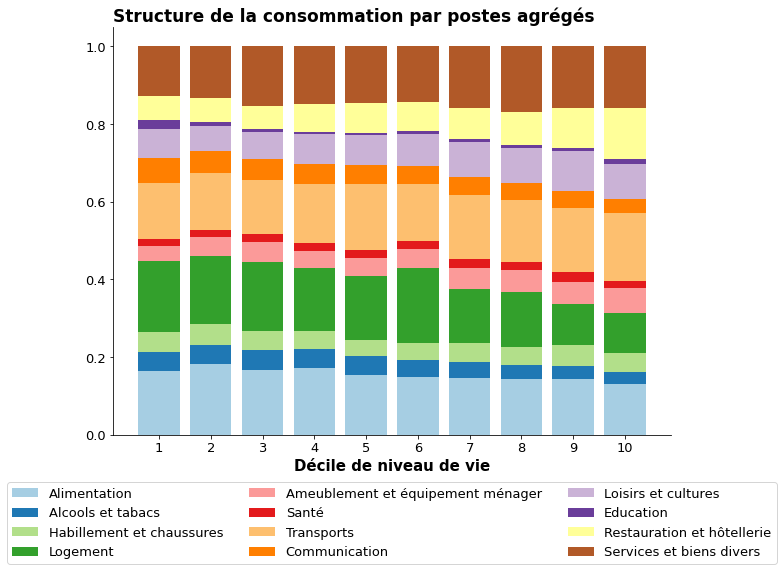

In [61]:
stacked_bar_plot(to_graph, 
                 variables = ["Part poste 0{}".format(i) for i in range(1, 10)] + ["Part poste {}".format(i) for i in range(10, 13)],
                 labels = label_postes_agreges,
                 title = 'Structure de la consommation par postes agrégés',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel = '',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Structure_conso_postes_agreges.pdf')

In [62]:
to_graph[['poste_04_1_1_1',
 'poste_04_1_2_1',
 'loyer_impute',
 'poste_04_3_1_1',
 'poste_04_3_2_1',
 'poste_04_4_1_1',
 'poste_04_4_2_1',
 'poste_04_4_3_1',
 'poste_04_4_4_1',
 'poste_04_5_0_0',
 'poste_04_5_1_1',
 'poste_04_5_2_1',
 'poste_04_5_2_2',
 'poste_04_5_3_1',
 'poste_04_5_4_1',
 'poste_04_5_5_1',
 'poste_04_5_5_2',
 'poste_04_6_1_1', 
 'depenses_tot']]

,poste_04_1_1_1,poste_04_1_2_1,loyer_impute,poste_04_3_1_1,poste_04_3_2_1,poste_04_4_1_1,poste_04_4_2_1,poste_04_4_3_1,poste_04_4_4_1,poste_04_5_0_0,poste_04_5_1_1,poste_04_5_2_1,poste_04_5_2_2,poste_04_5_3_1,poste_04_5_4_1,poste_04_5_5_1,poste_04_5_5_2,poste_04_6_1_1,depenses_tot
niveau_vie_decile,,,,,,,,,,,,,,,,,,,
1,1907.937079,16.728339,3568.381437,28.920145,320.558837,109.632986,35.317884,0.0,174.211737,0.0,748.821318,240.468909,40.067364,72.433489,54.428752,53.613426,0.000000,0.0,20893.529419
2,1950.465484,12.693858,3653.295564,40.462233,96.679934,130.983522,342.044849,0.0,191.000594,0.0,787.313254,293.149621,48.909271,99.475437,73.551009,27.536447,0.000000,0.0,23282.715674
3,2159.462762,10.108496,4336.550635,45.548174,275.582831,134.563086,263.041454,0.0,168.796585,0.0,804.450904,323.802879,61.912705,97.988729,86.285028,23.589282,0.000000,0.0,24991.114575
4,2197.179932,23.289489,5280.474352,64.266287,102.320054,147.339079,213.331365,0.0,153.728166,0.0,864.879421,327.279199,59.539329,135.033468,86.226738,217.165739,18.544286,0.0,28404.254592
5,2203.446030,20.949455,5747.687996,76.957131,957.457010,150.803288,55.593569,0.0,136.583090,0.0,879.556499,320.735680,57.118193,119.504298,97.200907,0.000000,17.984981,0.0,30729.237421
6,2150.324103,24.633456,6585.720201,71.820299,2599.230955,163.878302,23.957663,0.0,168.021964,0.0,937.064753,331.608857,48.329083,112.793320,99.517380,44.347191,17.246770,0.0,35081.071889
7,1954.227856,44.989647,7262.610366,206.448839,731.108669,161.119869,135.219853,0.0,151.820355,0.0,992.581975,378.725528,49.067604,110.006070,98.679010,0.000000,36.749768,0.0,36272.037448
8,1969.173079,26.256398,8158.808756,94.538358,1392.984727,171.574635,297.104017,0.0,173.724527,0.0,989.338783,362.383509,52.201572,121.619960,91.298057,92.685536,22.153642,0.0,41585.296027
9,1823.483854,38.618799,9473.473873,110.227168,465.367370,177.282944,55.315292,0.0,196.761419,0.0,1090.857344,425.411742,36.911233,87.996634,98.207916,53.099599,0.000000,0.0,44173.197241


In [63]:
to_graph['loyers'] = to_graph['poste_04_1_1_1'] + to_graph['poste_04_1_2_1'] + to_graph['loyer_impute']
to_graph['part loyer'] = to_graph['loyers'] / to_graph['depenses_tot']
to_graph[['loyers', 'depenses_tot', 'part loyer']]

,loyers,depenses_tot,part loyer
niveau_vie_decile,,,
1,5493.046855,20893.529419,0.262907
2,5616.454906,23282.715674,0.241229
3,6506.121894,24991.114575,0.260337
4,7500.943773,28404.254592,0.264078
5,7972.083480,30729.237421,0.259430
6,8760.677759,35081.071889,0.249727
7,9261.827868,36272.037448,0.255343
8,10154.238233,41585.296027,0.244179
9,11335.576525,44173.197241,0.256617


### Structure de la consommation par taux de TVA 

In [64]:
to_graph[['depenses_tva_taux_plein' , 'depenses_tva_taux_intermediaire', 'depenses_tva_taux_reduit','depenses_tva_taux_super_reduit','depenses_tva_exonere','depenses_tot']]

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,depenses_tva_exonere,depenses_tot
niveau_vie_decile,,,,,,
1,9592.019393,2305.617988,4433.775011,143.436817,4418.680151,20893.529419
2,10865.355764,2392.693492,5261.111902,252.303417,4511.251043,23282.715674
3,11861.266446,2600.991628,5216.132440,242.165558,5070.558551,24991.114575
4,13291.440139,2924.785334,6174.801387,303.129141,5710.098599,28404.254592
5,14352.336494,4111.796081,6278.118548,345.301152,5641.685232,30729.237421
6,15677.808973,6242.127877,6896.099858,366.110996,5898.924250,35081.071889
7,17405.516016,4895.303103,7669.751667,348.946767,5952.519948,36272.037448
8,19891.984212,6276.906453,8872.664675,414.589792,6129.150823,41585.296027
9,21251.795057,6941.679975,9282.190788,522.141218,6175.390130,44173.197241


In [65]:
to_graph.loc[:,'Part TVA exonere'] = to_graph['depenses_tva_exonere'] / to_graph['depenses_tot']
to_graph.loc[:,'Part TVA taux super réduit'] = to_graph['depenses_tva_taux_super_reduit'] / to_graph['depenses_tot']
to_graph.loc[:,'Part TVA taux réduit'] = to_graph['depenses_tva_taux_reduit'] / to_graph['depenses_tot']
to_graph.loc[:,'Part TVA taux intermédiaire'] = to_graph['depenses_tva_taux_intermediaire'] / to_graph['depenses_tot']
to_graph.loc[:,'Part TVA taux plein'] = to_graph['depenses_tva_taux_plein'] / to_graph['depenses_tot']

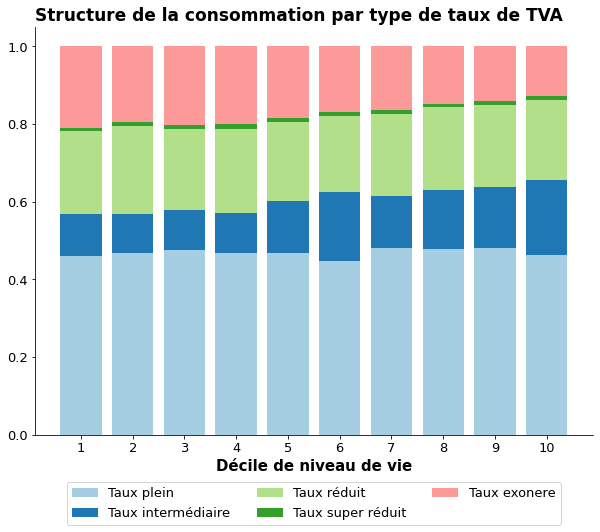

In [66]:
stacked_bar_plot(to_graph, 
                 variables = ['Part TVA taux plein','Part TVA taux intermédiaire','Part TVA taux réduit','Part TVA taux super réduit','Part TVA exonere'],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit','Taux exonere'],
                 title = 'Structure de la consommation par type de taux de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Structure_conso_taux_tva_avec_exo.pdf')

In [67]:
to_graph.loc[:,'Part TVA taux super réduit'] = to_graph['depenses_tva_taux_super_reduit'] / to_graph['depenses_totales']
to_graph.loc[:,'Part TVA taux réduit'] = to_graph['depenses_tva_taux_reduit'] / to_graph['depenses_totales']
to_graph.loc[:,'Part TVA taux intermédiaire'] = to_graph['depenses_tva_taux_intermediaire'] / to_graph['depenses_totales']
to_graph.loc[:,'Part TVA taux plein'] = to_graph['depenses_tva_taux_plein'] / to_graph['depenses_totales']

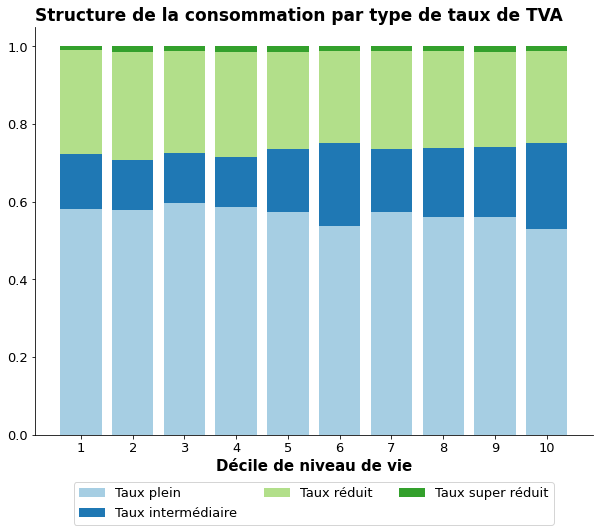

In [68]:
stacked_bar_plot(to_graph, 
                 variables = ['Part TVA taux plein','Part TVA taux intermédiaire','Part TVA taux réduit','Part TVA taux super réduit'],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Structure de la consommation par type de taux de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Structure_conso_taux_tva.pdf')

In [69]:
total_graph = pd.DataFrame(to_graph[['depenses_tva_taux_plein' , 'depenses_tva_taux_intermediaire', 
          'depenses_tva_taux_reduit','depenses_tva_taux_super_reduit',
          'depenses_tva_exonere','depenses_tot', 'depenses_totales','tva_total']].mean()).T

In [70]:
total_graph.loc[:,'Part TVA exonere'] = total_graph['depenses_tva_exonere'] / total_graph['depenses_tot']
total_graph.loc[:,'Part TVA taux super réduit'] = total_graph['depenses_tva_taux_super_reduit'] / total_graph['depenses_tot']
total_graph.loc[:,'Part TVA taux réduit'] = total_graph['depenses_tva_taux_reduit'] / total_graph['depenses_tot']
total_graph.loc[:,'Part TVA taux intermédiaire'] = total_graph['depenses_tva_taux_intermediaire'] / total_graph['depenses_tot']
total_graph.loc[:,'Part TVA taux plein'] = total_graph['depenses_tva_taux_plein'] / total_graph['depenses_tot']

In [71]:
total_graph[['Part TVA exonere','Part TVA taux super réduit','Part TVA taux réduit','Part TVA taux intermédiaire','Part TVA taux plein']]

,Part TVA exonere,Part TVA taux super réduit,Part TVA taux réduit,Part TVA taux intermédiaire,Part TVA taux plein
0,0.165625,0.010347,0.210065,0.145044,0.468919


In [72]:
total_graph.loc[:,'Part TVA taux super réduit'] = total_graph['depenses_tva_taux_super_reduit'] / total_graph['depenses_totales']
total_graph.loc[:,'Part TVA taux réduit'] = total_graph['depenses_tva_taux_reduit'] / total_graph['depenses_totales']
total_graph.loc[:,'Part TVA taux intermédiaire'] = total_graph['depenses_tva_taux_intermediaire'] / total_graph['depenses_totales']
total_graph.loc[:,'Part TVA taux plein'] = total_graph['depenses_tva_taux_plein'] / total_graph['depenses_totales']

In [73]:
total_graph[['Part TVA taux super réduit','Part TVA taux réduit','Part TVA taux intermédiaire','Part TVA taux plein']]

,Part TVA taux super réduit,Part TVA taux réduit,Part TVA taux intermédiaire,Part TVA taux plein
0,0.012401,0.251763,0.173836,0.562


# Taux Effectif moyen TVA (2019)

In [74]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'loyer_impute',
'tva_taux_plein',
 'tva_taux_intermediaire',
 'tva_taux_reduit',
 'tva_taux_super_reduit',
 'tva_total',
 'niveau_de_vie',
 'rev_disponible',
 'decile_rev_disponible',
 'rev_disp_yc_loyerimpute',
 'depenses_tot',
 'pondmen']

In [ ]:
inflators_by_year = get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[2017])
survey_scenario = SurveyScenario.create(
    inflation_kwargs = inflation_kwargs,
    year = 2019,
    data_year = data_year,
    )
to_graph = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', variables = simulated_variables, aggfunc = 'sum')

In [76]:
tva_total = survey_scenario.compute_aggregate('tva_total', use_baseline= False, period = 2019)
depenses_totales = survey_scenario.compute_aggregate('depenses_totales', use_baseline= False, period = 2019)

In [77]:
tva_total / depenses_totales

0.12260122284969828

# Réforme TVA

In [ ]:
from openfisca_france_indirect_taxation.projects.TVA.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [79]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_ht_tva_taux_plein',
'depenses_ht_tva_taux_intermediaire',
'depenses_ht_tva_taux_reduit',
'depenses_ht_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'loyer_impute',
'depenses_ht_tva_taux_plein',
'tva_taux_plein',
 'tva_taux_intermediaire',
 'tva_taux_reduit',
 'tva_taux_super_reduit',
 'tva_total',
 'niveau_de_vie',
 'rev_disponible',
 'decile_rev_disponible',
 'rev_disp_yc_loyerimpute',
 'depenses_tot',
 'pondmen']

In [ ]:
year = 2024
data_year = 2017
inflators_by_year = get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

In [81]:
survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    data_year = data_year
    )

reforme_all = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', difference = True, 
                                 variables = ['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']],
                                 aggfunc = 'mean')
rev_disponible_2024 = dataframe_by_group(survey_scenario, category = 'niveau_vie_decile', use_baseline= True, variables = ['niveau_de_vie'], aggfunc = 'mean')

In [82]:
reforme_all = reforme_all.merge(rev_disponible_2024, how = 'left', right_index = True, left_index = True)

In [83]:
recolte_taux_plein = survey_scenario.compute_aggregate(variable='tva_taux_plein',difference= True, period = year) * 1e-9
recolte_taux_inter = survey_scenario.compute_aggregate(variable='tva_taux_intermediaire',difference= True, period = year) * 1e-9
recolte_taux_reduit = survey_scenario.compute_aggregate(variable='tva_taux_reduit',difference= True, period = year) * 1e-9
recolte_taux_super_reduit = survey_scenario.compute_aggregate(variable='tva_taux_super_reduit',difference= True, period = year) * 1e-9

In [84]:
recolte_taux_plein

4.590871013514985

In [85]:
recolte_taux_inter

1.8708319844531023

In [86]:
recolte_taux_reduit

2.4757302957167187

In [87]:
recolte_taux_super_reduit

0.09822063545978278

In [88]:
recolte_taux_plein + recolte_taux_inter + recolte_taux_reduit + recolte_taux_super_reduit

9.035653929144587

In [89]:
tva_total = survey_scenario.compute_aggregate(variable='tva_total', use_baseline= True, period = year) * 1e-9
depenses_ht_totales = (survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_plein', use_baseline= True, period = year) +
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_intermediaire', use_baseline= True, period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_reduit', use_baseline= True, period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_super_reduit', use_baseline= True, period = year)
 )* 1e-9

In [90]:
depenses_ht_totales

903.5659473343367

In [91]:
taux_moyen = tva_total / depenses_ht_totales
taux_moyen

0.13761986254772016

In [92]:
'depenses_ht_tva_taux_plein',
'depenses_ht_tva_taux_intermediaire',
'depenses_ht_tva_taux_reduit',
'depenses_ht_tva_taux_super_reduit',

('depenses_ht_tva_taux_super_reduit',)

In [93]:
reforme_all

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,niveau_de_vie
niveau_vie_decile,,,,,
1.0,97.097675,30.037615,53.850428,1.415692,12634.352676
2.0,109.817901,31.165574,63.513949,2.450571,19885.101626
3.0,119.523364,34.122656,62.661295,2.327527,23978.777674
4.0,134.234378,38.733902,74.563449,2.910541,27670.889724
5.0,144.889799,54.350293,75.481935,3.321833,31079.178702
6.0,157.318493,81.486877,82.665619,3.544574,34673.081094
7.0,173.582040,64.469982,91.819181,3.366239,38695.357165
8.0,198.160597,82.022134,106.364999,4.029024,44021.684774
9.0,211.336316,91.869218,111.554332,5.125065,52116.378047


In [94]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
for taux in liste_taux:
   reforme_all['Taux_effort_tva_taux_{}'.format(taux)] = reforme_all['depenses_tva_taux_{}'.format(taux)] / reforme_all['niveau_de_vie'] * 100

In [95]:
reforme_all

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,niveau_de_vie,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit
niveau_vie_decile,,,,,,,,,
1.0,97.097675,30.037615,53.850428,1.415692,12634.352676,0.768521,0.237746,0.426222,0.011205
2.0,109.817901,31.165574,63.513949,2.450571,19885.101626,0.552262,0.156728,0.319405,0.012324
3.0,119.523364,34.122656,62.661295,2.327527,23978.777674,0.498455,0.142304,0.261320,0.009707
4.0,134.234378,38.733902,74.563449,2.910541,27670.889724,0.485110,0.139981,0.269465,0.010518
5.0,144.889799,54.350293,75.481935,3.321833,31079.178702,0.466196,0.174877,0.242870,0.010688
6.0,157.318493,81.486877,82.665619,3.544574,34673.081094,0.453719,0.235015,0.238414,0.010223
7.0,173.582040,64.469982,91.819181,3.366239,38695.357165,0.448586,0.166609,0.237287,0.008699
8.0,198.160597,82.022134,106.364999,4.029024,44021.684774,0.450143,0.186322,0.241620,0.009152
9.0,211.336316,91.869218,111.554332,5.125065,52116.378047,0.405508,0.176277,0.214049,0.009834


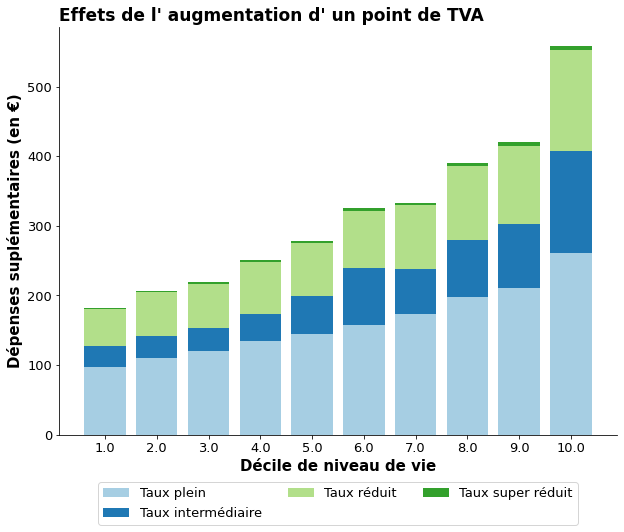

In [96]:
stacked_bar_plot(reforme_all, 
                 variables = ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires (en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = 'Effet_net_augmentation_TVA.pdf')

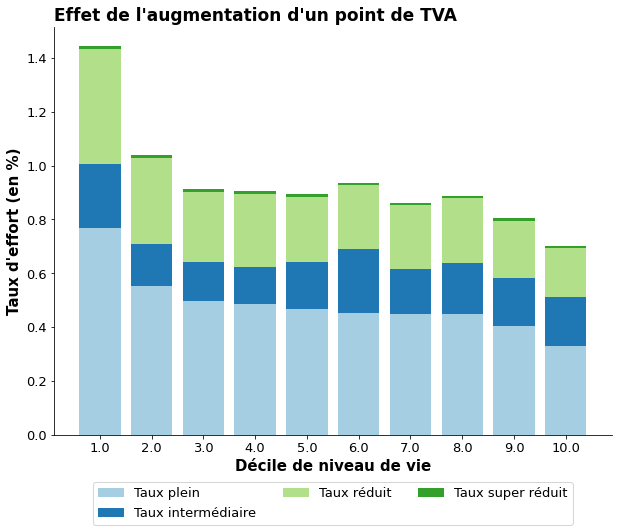

In [97]:
stacked_bar_plot(reforme_all, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effet de l\'augmentation d\'un point de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Taux d\'effort (en %)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = 'Taux_effort.pdf')

In [98]:
from openfisca_france_indirect_taxation.variables.base import get_legislation_data_frames

In [99]:
categories_fiscales_data_frame, codes_coicop_data_frame = get_legislation_data_frames()

In [100]:
pd.set_option('display.max_rows',None)

In [101]:
categories_fiscales_data_frame.loc[categories_fiscales_data_frame['categorie_fiscale'] == 'tva_taux_super_reduit']

,code_bdf,categorie_fiscale,start,stop,label,Label,formatted_code_bdf,code_coicop
146,c06111,tva_taux_super_reduit,1994,2024,Produits pharmaceutiques à ingurgiter et trait...,Produits pharmaceutiques à ingurgiter et trait...,06.1.1.1,06.1.1.1
214,c09521,tva_taux_super_reduit,1994,2024,Journaux et périodiques yc par abonnement,Journaux et périodiques,09.5.2.1,09.7.2.1


In [102]:
set(categories_fiscales_data_frame['categorie_fiscale'])

{'',
 'alcools_forts',
 'assurance_sante',
 'assurance_transport',
 'autres_assurances',
 'biere',
 'cigares',
 'cigarettes',
 'tabac_a_rouler',
 'ticpe',
 'tva_taux_intermediaire',
 'tva_taux_plein',
 'tva_taux_reduit',
 'tva_taux_super_reduit',
 'vin'}